## Projectile Distance vs Launch Angle
Here Euler's method is used to simulate the motion of a small projectile. We will start with the case of the projectile being in a vacuum near Earth and then include the effects of air resistance, first by considering drag and then by accounting for spin.

In [1]:
# Constants
g = 9.81           # acceleration due to gravity [m/s^2]
dt = 0.01          # time step [s]
rho = 1.225        # density of air at sea level 15 Celsius [kg/m^3]
A = 0.0015         # cross-sectional area of projectile [m^s]
m = 0.05           # mass of projectile [kg]
Somega = 0.01      # rough backspin constant (Magnus Effect) [kg/s]

In [2]:
# Options for Effects
# 1: vacuum
# 2: drag
# 3: drag and spin
option = 1

In [3]:
# drag coefficient
def C(v):    
    if v < 14:
        return .5
    return 7./v

The equations of motion for a projectile in a vacuum near Earth.

\begin{align*}
\frac{dx}{dt} = v_x & \qquad
\frac{dy}{dt} = v_y \\
\frac{dv_x}{dt} = 0 & \qquad
\frac{dv_y}{dt} = -g
\end{align*}

In [4]:
from numpy import zeros

def f_vacuum(r):
    dfdt = zeros(4)
    
    dfdt[0] = r[2]
    dfdt[1] = r[3]
    dfdt[2] = 0
    dfdt[3] = -g
    
    return dfdt

The equations of motion for a projectile experiencing air resistance causing drag but no spin.

\begin{align*}
\frac{dx}{dt} = v_x & \qquad
\frac{dy}{dt} = v_y \\
\frac{dv_x}{dt} = -\frac{C\rho Av_xv}{m} & \qquad
\frac{dv_y}{dt} = -g - \frac{C\rho Av_yv}{m}
\end{align*}

In [5]:
from numpy import sqrt

def f_drag(r):
    dfdt = zeros(4)
    
    v = sqrt(r[2]**2 + r[3]**2)
    dfdt[0] = r[2]
    dfdt[1] = r[3]
    dfdt[2] = -C(v)*rho*A*r[2]*v/m
    dfdt[3] = -g - C(v)*rho*A*r[3]*v/m
    
    return dfdt

The equations of motion for a projectile experiencing air resistance causing drag and spin.

\begin{align*}
\frac{dx}{dt} = v_x & \qquad
\frac{dy}{dt} = v_y \\
\frac{dv_x}{dt} = -\frac{C\rho Av_xv}{m} - \frac{S\omega v_y}{m} & \qquad
\frac{dv_y}{dt} = -g - \frac{C\rho Av_yv}{m} + \frac{S\omega v_x}{m}
\end{align*}

In [6]:
def f_drag_spin(r):
    dfdt = zeros(4)
    
    v = sqrt(r[2]**2 + r[3]**2)
    dfdt[0] = r[2]
    dfdt[1] = r[3]
    dfdt[2] = -(C(v)*rho*A*r[2]*v + Somega*r[3])/m
    dfdt[3] = -g - (C(v)*rho*A*r[3]*v - Somega*r[2])/m
    
    return dfdt

In [7]:
from numpy import arange

if option == 1:
    f = f_vacuum
    launch_angles = arange(5, 86, 5)
    system = 'vacuum'
if option == 2:
    f = f_drag
    launch_angles = arange(5, 86, 5)
    system = 'drag'
if option == 3:
    f = f_drag_spin
    launch_angles = arange(.5, 20.1, .5)
    system = 'drag and spin'

In [8]:
from numpy import cos, sin, pi

# initialize list for horizontal distances travelled
distances = []
# run numerical integration
for theta0 in launch_angles:
    # initial conditions
    v0 = 70            # launch speed [m/s]
    r = zeros(4)
    r[0], r[1] = 0., 0.    # start at origin
    r[2] = v0*cos(theta0*pi/180)  # x-velocity [m/s]
    r[3] = v0*sin(theta0*pi/180)  # y-velocity [m/s]
    
    while r[1] >= 0.:  # run for duration of flight
        r += f(r)*dt
    distances.append(r[0])

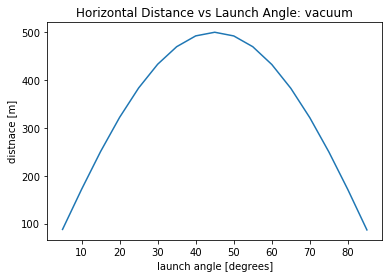

In [9]:
from pylab import figure, plot, xlabel, ylabel, title, show

figure(1)
plot(launch_angles, distances)
xlabel('launch angle [degrees]'), ylabel('distnace [m]')
title('Horizontal Distance vs Launch Angle: {}'.format(system))
show()

Now let's plot the trajectory of the projectile when it is launched at the angle that results in the furthest horizontal distance travelled.

In [10]:
from numpy import argmax

max_index = argmax(distances)
max_angle = launch_angles[max_index]
r = zeros(4)
r[0], r[1] = 0., 0.
r[2] = v0*cos(max_angle*pi/180)
r[3] = v0*sin(max_angle*pi/180)

In [11]:
# initialize lists for plotting
x_optimal = []
y_optimal = []

while r[1] >= 0.:
    x_optimal.append(r[0])
    y_optimal.append(r[1])
    
    r+= f(r)*dt

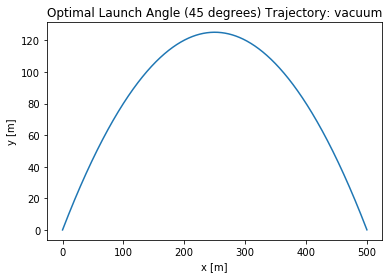

In [12]:
figure(2)
plot(x_optimal, y_optimal)
title('Optimal Launch Angle ({} degrees) Trajectory: {}'.format(max_angle, system))
xlabel('x [m]'), ylabel('y [m]')
show()

## Distribution of Projectile Ranges
Now we launch the projectile several times at random initial angles chosen from a range of angles with equal probability for each angle. The distribution of distances will be investigatedto determine how likely a projectile is to land within tolerance of a certain target distance.

In [13]:
theta_min = 1
theta_max = 70
TOL = 0.10      # 10% tolerance
target = 100    # target distance [m]
tol = TOL*target
N = 5000        # number of trials

In [14]:
# initialize arrays for plotting
launch_angles = zeros(N)
distances = zeros(N)

In [15]:
from random import random

for trial in range(N):
    # initial conditions
    theta0 = theta_min + random()*(theta_max-theta_min)
    v0 = 70
    r = zeros(4)
    r[0], r[1] = 0., 0.
    r[2] = v0*cos(theta0*pi/180)
    r[3] = v0*sin(theta0*pi/180)
    
    while r[1] >= 0.:
        r += f(r)*dt
    distances[trial] = r[0]
    launch_angles[trial] = theta0

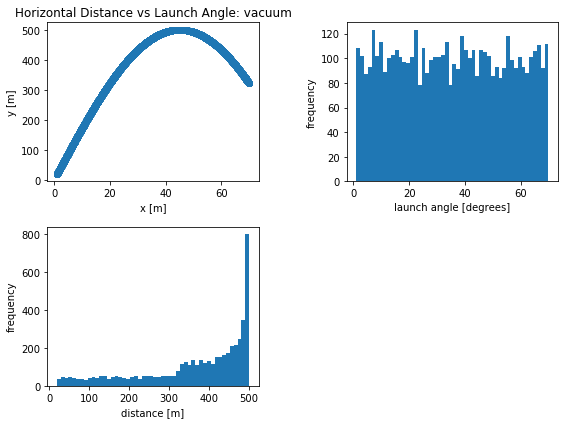

In [16]:
from pylab import subplot, scatter, hist, tight_layout

figure(3, figsize=(8, 6))
subplot(221)
scatter(launch_angles, distances)
xlabel('x [m]'), ylabel('y [m]')
title('Horizontal Distance vs Launch Angle: {}'.format(system))

subplot(222)
hist(launch_angles, bins=50)
xlabel('launch angle [degrees]'), ylabel('frequency')

subplot(223)
hist(distances, bins=50)
xlabel('distance [m]'), ylabel('frequency')

tight_layout()
show()

In [17]:
in_tol = ((target-tol < distances) & (distances < target+tol)).sum()
print(100*in_tol/N, 'percent of trials are withing tolerance of the target distance:', system)

1.5 percent of trials are withing tolerance of the target distance: vacuum
